In [2]:
import csv
import datetime

In [63]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [ ]:
NYCLoc=[40.7127,-74.0059] #Use a lat/lon in NYC to compare against.  Taxi rides from >100km excluded.

In [297]:
def checkDict(key,dict):
    if key not in dict:
        dict[key]=1
    else: dict[key]+=1

In [332]:
#Initialize some variables
cacheDateL=datetime.datetime.strptime('2100-12-01 00:00:00', "%Y-%m-%d %H:%M:%S")
cacheDateH=datetime.datetime.strptime('2000-12-01 00:13:00', "%Y-%m-%d %H:%M:%S")
cacheLat=-99999
cacheLong=-99999
tripDistanceBins = [0.5,.75,1,1.5,2,3,4,5,10,25]

distBin = {k:0 for k in tripDistanceBins}
LatLow=9999
LongLow=999
tripTotal=0
counter = 0
trips = 0
tripTotal=0
dateDict = {k:[0,0] for k in range(0,24)}
medallionDict={}
licenseDict={}
vendorDict={}
rate_codeDict={}
flagDict={}
flag=0

#create a blank file to hold the subset data
subFile='NYC_Taxi_Subset.csv'
f2 = open(subFile,'w')
f2.write('')
f2.close()

f2 = open(subFile,'a')
writer = csv.writer(f2,delimiter=',',lineterminator='\n')

#loop through the larger dataset
with open('trip_data_12.csv') as file:
    data=csv.reader(file)
    for line in data:
        if counter == 0:
            writer.writerow(line)
            dictData = {k: None for k in line} #make a dictionary
        if counter>0:
            if counter % 1000 == 0: #write a subset for every 1000 rows.
                writer.writerow(line)
            #this dictionary section generating unique values for categorical items.  it saves the counts of occurances.
            checkDict(line[0],medallionDict)
            checkDict(line[1],licenseDict)
            checkDict(line[2],vendorDict)
            checkDict(line[3],rate_codeDict)
            checkDict(line[4],flagDict)

            #Check that the trip distance is a number higher than 0, otherwise ignore.
            if float(line[8])>0:

                #Binning section for trip distances.
                for i in tripDistanceBins:
                    if float(line[9]) <i:
                        distBin[i]+=1
                        break
                    if i == len(tripDistanceBins):
                        distBin[i] +=1
                
                currentDate=datetime.datetime.strptime(line[5], "%Y-%m-%d %H:%M:%S")

                #create the binning for hour.  All days included in the average
                dateDict[currentDate.hour][0] += 1
                dateDict[currentDate.hour][1] += int(line[7])

                tripDistance=haversine(float(line[10]),float(line[11]),float(line[12]),float(line[13]))
                
                #Ensure the NYC taxi data starts within 100km of a reference point to force data integrity.
                if haversine(NYCLoc[1],NYCLoc[0],float(line[10]),float(line[11])) < 100:
                    if counter < 500 and flag == 0:
                        acounter=0
                        for k in dictData.keys():
                            dictData[k] = line[acounter]
                            acounter+=1
                    if tripDistance != 0 and float(line[9]) != 0:
                        if 0.05 < tripDistance/float(line[9]) < 2:
                            trips+=1
                            tripTotal+=tripDistance

                            if (float(line[10]) > float(cacheLong) and float(line[10]) < 0): cacheLong=float(line[10])
                            if (float(line[10]) < LongLow): LongLow=float(line[10])
    
                            if (float(line[11]) > float(cacheLat) and float(line[11]) > 20): cacheLat=float(line[11])
                            if (float(line[11]) < LatLow and float(line[11]) > 20): LatLow=float(line[11])
                    if currentDate>cacheDateH:
                        cacheDateH=currentDate
                    if currentDate<cacheDateL:
                        cacheDateL=currentDate
        counter +=1
        if counter > 1000000:
            break

f2.close()

In [320]:
dictData

{'medallion': 'C13BD886F362AC4D71FEB912091AB76A',
 ' hack_license': '3FC36031EAC645D019BAC9C263F21CF7',
 ' vendor_id': 'VTS',
 ' rate_code': '1',
 ' store_and_fwd_flag': '',
 ' pickup_datetime': '2013-12-30 14:14:00',
 ' dropoff_datetime': '2013-12-30 14:37:00',
 ' passenger_count': '2',
 ' trip_time_in_secs': '1380',
 ' trip_distance': '7.08',
 ' pickup_longitude': '-74.001427',
 ' pickup_latitude': '40.746643',
 ' dropoff_longitude': '-73.952324',
 ' dropoff_latitude': '40.826633'}

trip_distance in kilometers.

In [323]:
haversine(float(dictData[' pickup_longitude']),float(dictData[' pickup_latitude']),float(dictData[' dropoff_longitude']),float(dictData[' dropoff_latitude']))

9.80826151321852

In [318]:
acounter=0
for k in dictData.keys():
    dictData[k] = line[acounter]
    acounter+=1

In [309]:
flagDict

{'': 999567, 'N': 421, 'Y': 12}

In [268]:
distBin

{0.5: 44108,
 0.75: 81805,
 1: 103392,
 1.5: 191344,
 2: 142078,
 3: 164859,
 4: 84285,
 5: 47682,
 10: 136277,
 25: 48691,
 'Above': 0}

In [281]:

distanceBinned = list(distBin.values())


In [307]:
line

['6454C60D38D768346785F94F4F8C407C',
 'BC447BB2441875006AA1954CFDF9FE97',
 'VTS',
 '1',
 '',
 '2013-12-10 06:38:00',
 '2013-12-10 06:49:00',
 '2',
 '660',
 '3.44',
 '-73.958473',
 '40.810467',
 '-73.981705',
 '40.767681']

In [212]:
dictData

{'medallion': None,
 ' hack_license': None,
 ' vendor_id': None,
 ' rate_code': None,
 ' store_and_fwd_flag': None,
 ' pickup_datetime': None,
 ' dropoff_datetime': None,
 ' passenger_count': None,
 ' trip_time_in_secs': None,
 ' trip_distance': None,
 ' pickup_longitude': None,
 ' pickup_latitude': None,
 ' dropoff_longitude': None,
 ' dropoff_latitude': None}

In [229]:
tripDistanceBins = [0,1,2,3,4,5,10,25]

distBin = {k:0 for k in tripDistanceBins}

distBin

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 10: 0, 25: 0}

In [ ]:
testing = float(line[9]) 

for i in tripDistanceBins:
    if testing<i:
        distBin[i-1]+=1
        break

In [273]:
print(len(tripDistanceBins))
print(len(distanceBinned))

10
11


In [274]:
distanceBinned

[44108, 81805, 103392, 191344, 142078, 164859, 84285, 47682, 136277, 48691, 0]

In [265]:
distBin

{0.5: 44108,
 0.75: 81805,
 1: 103392,
 1.5: 191344,
 2: 142078,
 3: 164859,
 4: 84285,
 5: 47682,
 10: 86932,
 25: 48691,
 50: 638,
 100: 16,
 'Above': 0}

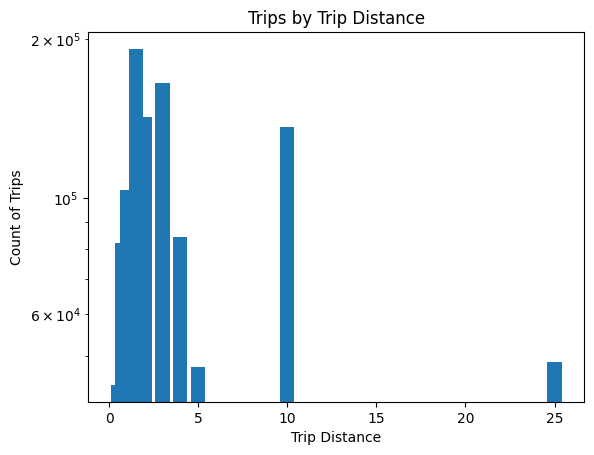

In [287]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(x=tripDistanceBins,height=distanceBinned)

ax.set_xlabel('Trip Distance')
ax.set_ylabel('Count of Trips')
#ax.set_ylim(0,2)
#ax.set_xlim(-1,24)
#ax.set_xticks(tripDistanceBins)
ax.set_title('Trips by Trip Distance')
ax.set_yscale('log')
plt.show()

In [194]:
haversine(NYCLoc[1],NYCLoc[0],float(line[10]),float(line[11]))

6.2158229002264624

In [193]:
NYCLoc

[40.7127, -74.0059]

In [207]:
dv=[]
height=[]
counter2=0
for items in dateDict.values():
    height.append(counter2)
    counter2+=1
    dv.append(items[1]/items[0])

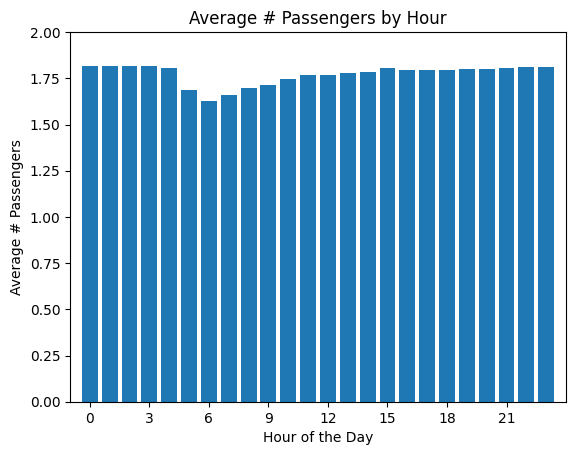

In [209]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(x=height,height=dv)

ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average # Passengers')
ax.set_ylim(0,2)
ax.set_xlim(-1,24)
ax.set_xticks([0,3,6,9,12,15,18,21])
ax.set_title('Average # Passengers by Hour')
plt.show()

In [210]:
print(f'The file has {counter-1} lines')
print(f'The latest date is : {cacheDateH}')
print(f'The earliest date is : {cacheDateL}')
print(f'The lat {cacheLat}')
print(f'The long {cacheLong}')
print(f'low long : {LongLow}')
print(f'low lat {LatLow}')
print(f'TotalDistance {tripTotal} and {trips} trips')
print(f'avg trip distance {tripTotal/trips}')

The file has 9993654 lines
The latest date is : 2013-12-31 23:59:57
The earliest date is : 2013-12-01 00:00:00
The lat 41.316311
The long -73.138115
low long : -74.802284
low lat 40.272701
TotalDistance 33058737.22242879 and 9535520 trips
avg trip distance 3.4669045025786525


In [211]:
print(f'''
{{
  "type": "FeatureCollection",
  "features": [

    {{
      "type": "Feature",
      "properties": {{}},
      "geometry": {{
        "coordinates": [
            [
                [{cacheLong},{cacheLat}],
                [{LongLow},{cacheLat}],
                [{LongLow},{LatLow}],
                [{cacheLong},{LatLow}],
                [{cacheLong},{cacheLat}]
            ]
        ],
        "type": "Polygon"
      }}
    }}
  ]
}}
'''
)


{
  "type": "FeatureCollection",
  "features": [

    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
            [
                [-73.138115,41.316311],
                [-74.802284,41.316311],
                [-74.802284,40.272701],
                [-73.138115,40.272701],
                [-73.138115,41.316311]
            ]
        ],
        "type": "Polygon"
      }
    }
  ]
}



{
  "type": "FeatureCollection",
  "features": [

    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -73.738625,
              40.871399
            ],
          [
              -73.738625,
              40.629185
            ],
            [
              -74.025742,
              40.629185
            ],
          [
            -74.025742,
            40.871399
            ],
                        [
              -73.738625,
              40.871399
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [327]:
subFile='NYC_Taxi_Subset.csv'
f2 = open(subFile,'w')
f2.write('')
f2.close()

f2 = open(subFile,'a')
writer = csv.writer(f2,delimiter=',',lineterminator='\n')

testCount=0
with open('trip_data_12.csv') as file:
    data=csv.reader(file)
    for line in data:
        writer.writerow(line)
        testCount+=1
        if testCount > 100:
            break
    

f2.close()

In [ ]:
#create blank file
for i in range(0,1000):
    if i % 100 == 0:
        print(i)
        #write to the blank file created

0
100
200
300
400
500
600
700
800
900
